In [123]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
# from scipy import signal
# from scipy.stats import entropy
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-poster')
import datetime

Модель ряда:

$$ 1.05\cos(\frac{2\pi}{24}n + \frac{3\pi}{4}) + 
                    0.82\cos(\frac{2\pi}{12} + \frac{\pi}{12}) + 
                    0.27\cos(\frac{2\pi}{8} - \frac{2\pi}{3}) + 
                    0.05\cos(\frac{2\pi}{6} - \frac{\pi}{3}) $$

In [252]:
def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = True, is_trend = False, change_type = 'mean'):
    if random_seed:
        np.random.seed(random_seed)
    
    signal_period = (1.05*np.cos((2*np.pi*np.arange(0, ts_length))/24 + (3*np.pi)/4) + 
                    0.82*np.cos((2*np.pi*np.arange(0, ts_length))/12 + np.pi/12) + 
                    0.27*np.cos((2*np.pi*np.arange(0, ts_length))/8 - (2*np.pi/3)) + 
                    0.05*np.cos((2*np.pi*np.arange(0, ts_length))/6 - np.pi/3))    
    
    if is_trend:
        trend_a = np.random.normal(0,0.005,1)
    else:    
        trend_a = 0
    signal_trend = trend_a*np.arange(1, ts_length+1)
    noise = np.random.normal(0,0.05,ts_length)
    signal = signal_trend+signal_period+noise

    change_point = np.random.choice(np.arange(points_to_skip,ts_length-points_to_skip),1)[0]
    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
    
    if change_type=='mean':
        change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value) <= 0.3:
            change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point:] = signal[change_point:]+change_point_value
        else:
            change_point_value = None
    elif change_type=='trend':
        
        trend_change = np.random.normal(0,0.005,1)
        while abs(trend_change - trend_a) <= 0.005:
            trend_change = np.random.normal(0,0.005,1)
        if change_point:
            change_point_value = signal_trend[change_point-1] + trend_change*np.arange(1, ts_length-change_point+1)
            signal[change_point:] = signal[change_point:] - signal_trend[change_point:] + change_point_value
        else:
            change_point_value = None
        
    elif change_type=='local':
        change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value <= 0.5):
            change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point] = signal[change_point]+change_point_value
        else:
            change_point_value = None
    else:
        raise ValueError("Wrong change point type")
    
    if is_multiplicative:
        signal = np.exp(signal)
    return([signal, change_point, change_point_value])


def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided
    
    
def approximation_mean(time_series, window, threshold=None):
    
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)
    
    all_ts_mean = np.convolve(time_series, np.ones((window,))/window, mode='valid')
    all_ts_slides = sliding_window(time_series, window)
    all_ts_cost = np.sum((all_ts_slides - all_ts_mean[:,None])**2,axis=1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    left_ts_cost = np.sum((left_right_ts_slides[:-half_window,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[half_window:,None])**2,axis=1)
    
    
    result.extend(list((all_ts_cost - left_ts_cost - right_ts_cost)/norm))
        
    return(result)

def prediction_mean(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[half_window:window] - np.mean(time_series[0:half_window]))**2)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    result.extend(list(right_ts_cost)/norm)

    return(result)

def naive(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    result.extend([abs(x/left_right_ts_mean[i-half_window]-1) for i, x in enumerate(left_right_ts_mean) if i >=half_window])
    
    return(result)

def cp_detection(cost_values, threshold):
    list_of_indexes = [ind for ind, cost_value in enumerate(cost_values) if cost_value > threshold]
    return(list_of_indexes)   

def cp_quality(actual, predicted, max_delay = 49):
    df = pd.DataFrame({'actual':actual, 'predicted':predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
    df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
    delay = list(df_temp['predicted'] - df_temp['actual'])
    df.loc[(pd.isna(df['actual']) == False) & 
           (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    
    df.loc[(pd.isna(df['actual']) == True) & (pd.isna(df['predicted']) == False), 'predicted_binary'] = 1
    df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['delay'] < 0) & (df['delay'] > max_delay), 'predicted_binary'] = 0
    df['predicted_binary'] = df['predicted_binary'].fillna(1)
    
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
    return(conf_m, delay) 


def cp_detection_modeling(approach = 'approximation_mean', iterations = 1000, max_delay = 49, _window = 48, _cp_prob = 0.8, _is_multiplicative = True, _threshold = 0.15, _is_trend = False, _change_type = 'mean'):
    act, pred = [], []
    for i in range(iterations):
        generated = data_generator(points_to_skip = _window, cp_prob = _cp_prob, is_multiplicative = _is_multiplicative, is_trend = _is_trend, change_type = _change_type)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], _window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], _window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], _window)
        else:
            raise ValueError("Unrecognized approach")
        cp_2 = cp_detection(cp_1, _threshold)
        
        act.append(generated[1])
        if generated[1] == None:
            if len(cp_2) == 0:
                pred.append(None)
            else:
                pred.append(cp_2[0])
        else:
            if len(cp_2) == 0:
                pred.append(None)
            else:
                pred_list = [cp for cp in cp_2
                                if ((cp - generated[1]) <= max_delay) &
                                   ((cp - generated[1]) >= 0)]
                if len(pred_list) == 0:
                    pred.append(None)
                else:
                    pred.append(pred_list[0])
        
        
    return([act, pred])


def get_threshold_list(iterations = 1000, approach = 'approximation_mean', window = 48, cp_prob = 0.8, is_multiplicative = False, is_trend = False, change_type = 'mean'):
    detection_values = []
    for i in range(iterations):    
        generated = data_generator(points_to_skip = window, cp_prob = cp_prob, is_multiplicative = is_multiplicative, is_trend = is_trend, change_type = change_type)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], window)
        else:
            raise ValueError("Unrecognized approach")
        detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
#     threshold_max = np.percentile(detection_values, 95)
    threshold_max = max(detection_values)*1.2
    threshold_max = float(round(threshold_max,6))
    threshold_list = list(np.arange(0, threshold_max, threshold_max/100))
    return(threshold_list)

In [243]:
WINDOWS = [72, 48, 24, 12, 6, 4, 2]
IS_TRENDS = [False, True]
CHANGE_TYPES = ['mean', 'trend', 'local']
# MAX_DELAYS = [49, 25, 13, 7, 4, 2]
MAX_DELAYS = [4]
APPROACHES = ['approximation_mean', 'prediction_mean', 'naive']

In [236]:
len(WINDOWS)*len(IS_TRENDS)*len(CHANGE_TYPES)*len(MAX_DELAYS)*len(APPROACHES)

126

In [254]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
# WINDOW = 48
# IS_TREND = False
# CHANGE_TYPE = 'mean'
# MAX_DELAY = 49
# APPROACH = 'approximation_mean'

df_results = pd.DataFrame(columns=['approach', 
                                   'max_delay', 
                                   'change_type', 
                                   'is_trend', 
                                   'window', 
                                   'cp_prob', 
                                   'is_multiplicative', 
                                   'ROC AUC'])


for WINDOW in WINDOWS:
    print(datetime.datetime.now())
    print(WINDOW)
    for IS_TREND in IS_TRENDS:
        for CHANGE_TYPE in CHANGE_TYPES:
            for MAX_DELAY in MAX_DELAYS:
                for APPROACH in APPROACHES:
                    threshold_list = get_threshold_list(iterations = ITERATIONS,
                                                        approach = APPROACH,
                                                        window = WINDOW, 
                                                        cp_prob = CP_PROB, 
                                                        is_multiplicative = IS_MULTIPLICATIVE, 
                                                        is_trend = IS_TREND, 
                                                        change_type = CHANGE_TYPE
                                                       )

                    # threshold_list = [x/100 for x in range(100)]
                    # threshold_list = [x/1000 for x in range(1000)]
                    actual, predicted, thresholds = [], [], []

                    for tr in threshold_list:
                        actual_temp, predicted_temp = cp_detection_modeling(iterations = ITERATIONS, 
                                                                  approach = APPROACH,
                                                                  max_delay = MAX_DELAY,
                                                                  _window = WINDOW,
                                                                  _cp_prob = CP_PROB,
                                                                  _is_multiplicative = IS_MULTIPLICATIVE,
                                                                  _threshold = tr,
                                                                  _is_trend = IS_TREND, 
                                                                  _change_type = CHANGE_TYPE
                                                                           )
                        actual.extend(actual_temp)
                        predicted.extend(predicted_temp)
                        thresholds.extend([tr]*len(actual_temp))

                    df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

                    precision = []
                    recall = []
                    specificity = []
                    average_delay = []
                    precision_filter = []
                    # test = []

                    for tr in threshold_list:
                        cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                                               df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                                               max_delay = MAX_DELAY
                                              )
                        if sum(cp_result[0][:,1]) == 0:
                            precision.append(1)
                        else:
                            precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

                        if sum(cp_result[0][1,:]) == 0:
                            recall.append(1)
                        else:
                            recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

                        if sum(cp_result[0][0,:]) == 0:
                            specificity.append(1)
                        else:
                            specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

                        if cp_result[1]:
                            average_delay.append(np.mean(cp_result[1]))
                            precision_filter.append(True)
                        else:
                            precision_filter.append(False)

                    #     test.append(cp_result[0])

                    unspecificity = [1-x for x in specificity]


                    unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))
                    df_results = df_results.append(pd.DataFrame(
                        {
                            'approach': APPROACH, 
                            'max_delay': MAX_DELAY, 
                            'change_type': CHANGE_TYPE,
                            'is_trend': IS_TREND,
                            'window': WINDOW, 
                            'cp_prob': CP_PROB, 
                            'is_multiplicative': IS_MULTIPLICATIVE, 
                            'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
                        }, index=[0]), ignore_index=True
                    )
#                     print('ROC AUC: {}'.format(np.trapz(unspecificity_sorted, recall_sorted)))

#                     plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
#                     plt.plot(unspecificity_sorted, recall_sorted)
#                     plt.ylabel('True positive rate')
#                     plt.xlabel('False positive rate')
#                     # plt.savefig('./fig/approximation_mean_2_roc.png')
#                     plt.show()

                    # plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
                    # plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
                    # plt.colorbar()
                    # plt.ylabel('True positive rate')
                    # plt.xlabel('False positive rate')
                    # plt.show()

2019-03-03 09:40:17.566108
72
2019-03-03 09:42:34.679808
48
2019-03-03 09:44:44.329314
24
2019-03-03 09:46:58.953827
12
2019-03-03 09:49:12.816281
6
2019-03-03 09:51:20.410208
4
2019-03-03 09:53:26.106356
2
CPU times: user 14min 52s, sys: 3.79 s, total: 14min 56s
Wall time: 15min 4s


In [131]:
# df_results_1 = df_results.copy()

In [255]:
df_results.head()

,ROC AUC,approach,change_type,cp_prob,is_multiplicative,is_trend,max_delay,window
0,0.187154,approximation_mean,mean,0.8,False,False,4,72
1,0.230597,prediction_mean,mean,0.8,False,False,4,72
2,0.437777,naive,mean,0.8,False,False,4,72
3,0.023115,approximation_mean,trend,0.8,False,False,4,72
4,0.072053,prediction_mean,trend,0.8,False,False,4,72


In [258]:
df_pivot = df_results.pivot_table(['ROC AUC'],
                         ['is_multiplicative',
                          'is_trend',
                          'change_type',
                          'max_delay',
                          'window'],
                         ['approach'])

In [259]:
cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

### Построим одну ROC кривую

ROC AUC: 0.04772565561665913


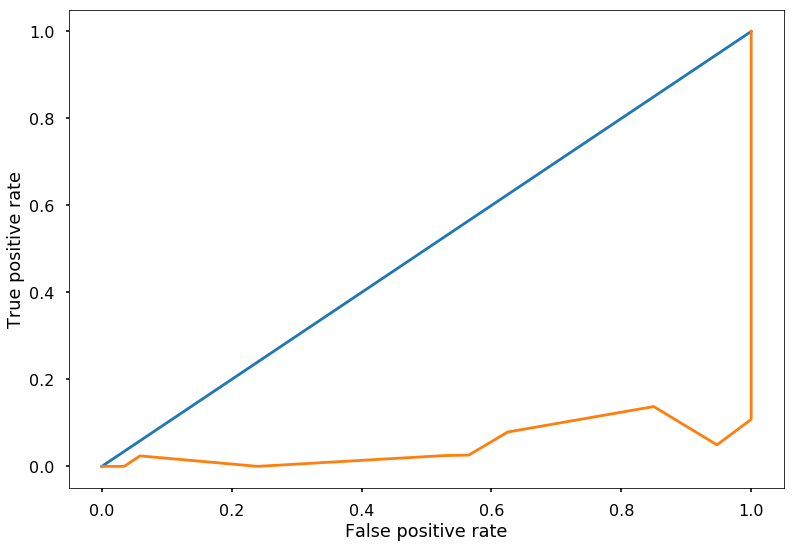

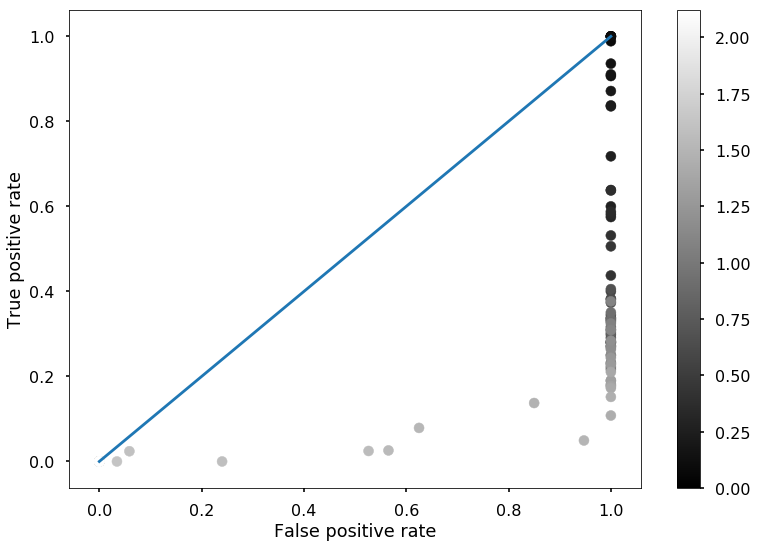

CPU times: user 7.49 s, sys: 68.6 ms, total: 7.56 s
Wall time: 7.62 s


In [178]:
%%time
# threshold_list = [x/100 for x in range(100)]
threshold_list = get_threshold_list(iterations = 100,
                                    window = 12,  
                                    is_multiplicative = False, 
                                    is_trend = True, 
                                    change_type = 'trend'
                                   )
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []

for tr in threshold_list:
    actual_temp, predicted_temp = cp_detection_modeling(iterations = 100, 
                                              max_delay = 4,
                                              _window = 12,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              _threshold = tr,
                                              _is_trend = True, 
                                              _change_type = 'trend'
                                                       )
    actual.extend(actual_temp)
    predicted.extend(predicted_temp)
    thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted'],
                           max_delay = 4
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
        
    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
        
    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    
    
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])

unspecificity = [1-x for x in specificity]


unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity_sorted, recall_sorted)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [210]:
# temp_tr = threshold_list[50]
# temp = cp_quality(df_cp.loc[df_cp['threshold'] == temp_tr, 'actual'], 
#                      df_cp.loc[df_cp['threshold'] == temp_tr, 'predicted'],
#                            max_delay = 4
#                           )[0]

# print(temp)
# print('Recall: {} \n FPR: {}'.format(temp[1,1]/sum(temp[1,:]),temp[0,1]/sum(temp[0,:]) ))

[[ 0 23]
 [52 25]]
Recall: 0.3246753246753247 
 FPR: 1.0
